# Practical 3: Recurrent Neural Networks (RNNs)




## Introduction

Feedforward models (eg deep MLPs and ConvNets) map fixed-size input-data (vectors of a fixed dimensionality) to their output labels. They're very powerful and have been successfully used for many tasks. However, a lot of data is not in the form of fixed-size vectors, but exists in the form of **sequences**. Language is one good example, where sentences are sequences of words. In some way, almost any data types can be considered as a sequence (for instance an image consists of a sequence of pixels, speech a sequence of phonemes, and so forth). 

Recurrent neural networks (**RNNs**) were designed to be able to handle sequential data, and in this practical we will take a closer look at RNNs and then build a model that can generate English sentences in the style of Shapespeare!

## Learning Objectives
* Understand how RNNs model sequential data.
* Understand how the vanilla RNN is a generalization of feedforward models to incorporate sequential dependencies.
* Understand the issues involved when training RNNs.
* Know how to implement an RNN in Keras and Tensorflow.

##Imports


In [1]:
#@title Imports (RUN ME!) { display-mode: "form" }

#!pip -q install pydot_ng
#!pip -q install graphviz
#!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf
import math
import random
import ssl
import sys
import urllib2
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('Running TensorFlow version %s' % (tf.__version__))
try:
  tf.enable_eager_execution()
  print('Eager mode activated.')
except ValueError:
  print('Already running in Eager mode')

Running TensorFlow version 1.10.1
Eager mode activated.


##From Feedforward to Recurrent Models

RNNs generalize feedforward networks (FFNs) to be able to work with sequential data. FFNs take an input (e.g. an image) and immediately produce an output (e.g. a digit class). RNNs, on the other hand, consider the data sequentially and remember what they have seen in the past in order to make new predictions about the future observations.

To understand this distinction, imagine we want to label words as the part-of-speech categories that they belong to: E.g. for the input sentence 'I want a duck' and 'He had to duck', we want our model to predict that duck is a `Noun` in the first sentence and a `Verb` in the second. To do this successfully, the model needs to be aware of the surrounding context. However, if we feed a FFN model only one word at a time, how could it know the difference? If we want to feed it all the words at once, how do we deal with the fact that sentences are of different lengths?

RNNs solve this issue by processing the sentence word-by-word, and maintaining an internal **state** summarizing what it has seen so far. This applies not only to words, but also to phonemes in speech, or even, as we will see, elements of a time-series.



In the feedforward models we've seen before, the input $x$ is mapped to an intermediate hidden layer $h$ as follows:

$h = \sigma(W_{xy}x + b)$

where $\sigma$ is some non-linear activation function like ReLU or tanh.  We can then make a prediction based on $h$, or we can add another layer, etc.

RNNs generalize this idea to a sequence of inputs $\mathcal{X} = {x_1, x_2, ...}$ by maintaining a sequence of state vectors $h_t$, one for every time-step $t$, as follows:

$h_t = \sigma(W_{hh}h_{t-1} + W_{xh}x_t + b)$

We can again use each $h_t$ to predict an output for that time-step $y_t$ (e.g. the part-of-speech of each word in a sentence), or we can just make one final prediction at the end (e.g. the topic of a document processed as a sequence of words).

**NOTE**: The weight subscript $W_{xz}$ is used to indicate a mapping from layer $x$ to layer $z$.

**QUESTIONS**
* How are FFNs and RNNs **similar**?
* How are they **different**?
* Why do we call RNNs "recurrent"?

##Modeling General Time-Series

We will train an RNN to model a time-series as a first step. A **time-series** is a series of data-points ordered over discrete time-steps. Examples include the hourly temperature of Stellenbosch over a month or a year, the market price of some asset (like a company's stock) over time, and so forth. We will generate a **sinusoidal time-series** (with or without noise) as a toy example, and then train a tiny RNN model with only 5 parameters on this data.

###Create some artificial data

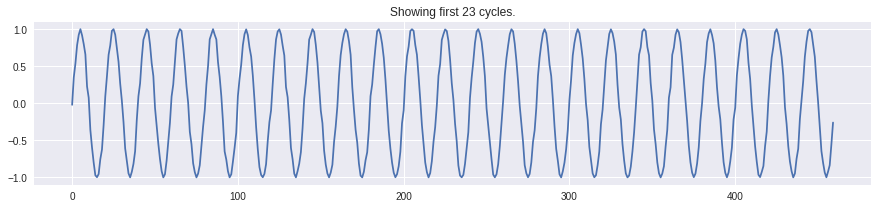

In [0]:
#@title Create sinusoidal data {run: "auto"}
steps_per_cycle = 20 #@param { type: "slider", min:1, max:100, step:1 }
number_of_cycles = 176 #@param { type: "slider", min:1, max:1000, step:1 }
noise_factor = 0.1 #@param { type: "slider", min:0, max:1, step:0.1 }
plot_num_cycles = 23 #@param { type: "slider", min:1, max:50, step:1 }

seq_len = steps_per_cycle * number_of_cycles
t = np.arange(seq_len)
sin_t = np.sin(2 * np.pi / steps_per_cycle * t + noise_factor * np.random.uniform(-1.0, +1.0, seq_len))
sin_t_clean = np.sin(2 * np.pi / steps_per_cycle * t)

upto = plot_num_cycles * steps_per_cycle
fig = plt.figure(figsize=(15,3))
plt.plot(t[:upto], sin_t[:upto])
plt.title("Showing first {} cycles.".format(plot_num_cycles))
plt.show()

#both = np.column_stack((t, sin_t))
#print("both.shape = {}".format(both.shape))

#print("both[:steps_per_cycle, :steps_per_cycle]")
#print(both[:steps_per_cycle,:steps_per_cycle])

**TASK**: Adjust the parameters above to generate data with different properties.

Now we pack the data into train and test batches. Note that while RNNs can in theory learn the dependencies across all inputs received so far (using an algorithm called **backpropagation through time**, or BPTT), in practice they are trained using an algorithm called **truncated BPTT** where we truncate the inputs to only the last N symbols (this is the `truncated_seq_len` variable below)

**QUESTION**: What are the pros and cons of truncating the training data in this way?

In [0]:
#@title Pack truncated sequence data {run: "auto"}

def pack_truncated_data(data, num_prev = 100):  
    X, Y = [], []
    for i in range(len(data) - num_prev):
      X.append(data[i : i + num_prev])
      Y.append(data[i + num_prev])
    # NOTE: We expand the last dimension, but this doesn't actually change the array.
    #X, Y = np.expand_dims(X, axis=2), np.expand_dims(Y, axis=1)
    X, Y = np.array(X)[:,:,np.newaxis], np.array(Y)[:,np.newaxis]
    return X, Y

# We only consider this many previous data points
truncated_seq_len = 5 #@param { type: "slider", min:1, max:10, step:1 }
test_split = 0.25  # Fraction of total data to keep out as test data

# We use only the sin_t values
data = sin_t
data_len = data.shape[0]
num_train = int(data_len * (1 - test_split))

train_data = data[:num_train]
test_data = data[num_train:]
X_train, y_train = pack_truncated_data(train_data, num_prev=truncated_seq_len)
X_test, y_test = pack_truncated_data(test_data, num_prev=truncated_seq_len)  

print("Generated training/test data with shapes\nX_train: {}, y_train: {}\nX_test: {}, y_test: {}. ".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))


Generated training/test data with shapes
X_train: (2635, 5, 1), y_train: (2635, 1)
X_test: (875, 5, 1), y_test: (875, 1). 


**QUESTION**: Can you explain what the different dimensions are for in **X** and **y**?

###Aside: Backpropagation-through-Time and Vanishing and Exploding Gradients

TODO(sgouws)

###Build a tiny RNN in Keras

In [0]:
def define_model(truncated_seq_len, 
                 batch_size = None, 
                 stateful = False):
    
    in_out_neurons = 1
    hidden_neurons = 1
    
    '''
    # This approach uses Keras's Functional API to build the model.
    # Notice how we have handles to the intermediate layers afterwards.    
    input_layer = tf.keras.layers.Input(
        batch_shape=(batch_size, truncated, in_out_neurons),
        name='input_layer') 
    hidden_layer = tf.keras.layers.SimpleRNN(
        hidden_neurons, 
        return_sequences=False,
        stateful = stateful, # Maintain state from one training instance to the next
        name='hidden_layer')(input_layer)
    output_layer = tf.keras.layers.Dense(
        in_out_neurons, 
        name='output_layer')(hidden_layer)
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

    '''
    
    # This approach uses Keras's Sequential API to build the model
    # Note that we don't specify a specific input layer, but we do need to specify the input shape.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.SimpleRNN(
        # We need to specify the input_shape *without* batch_size (it is inferred)
        input_shape=(truncated_seq_len, in_out_neurons),
        units=hidden_neurons, 
        return_sequences=False,
        stateful=stateful, # Maintain state from one training instance to the next
        name='hidden_layer'))
    model.add(tf.keras.layers.Dense(
        in_out_neurons, 
        name='output_layer'))

    model.compile(loss="mean_squared_error", 
                  optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-3))
    
    return model #, (input_layer, hidden_layer, output_layer)


In [0]:
# The Functional Way
#model, (input_layer, hidden_layer, output_layer) = define_model(truncated_seq_len = X_train.shape[1])
model = define_model(truncated_seq_len = X_train.shape[1])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**NOTE**: You need to re-run the above cell every time after training to reset the model weights!

###Train the tiny RNN
Now let's train the model. This may take a few minutes (it takes much longer if you increase `truncated_seq_len`). Set `verbose=1` **before** you run the cell to see the intermediate output as the model is training. Set it to 0 if you don't want any output.

In [0]:
patience = 5
train_history = model.fit(X_train, y_train, batch_size=600, epochs=1000, 
                          verbose=1, validation_split=0.05,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)])

Train on 2503 samples, validate on 132 samples
Epoch 1/1000
2503/2503 [==============================] - 0s 58us/step - loss: 0.3582 - val_loss: 0.3518
Epoch 2/1000
2503/2503 [==============================] - 0s 50us/step - loss: 0.3571 - val_loss: 0.3505
Epoch 3/1000
2503/2503 [==============================] - 0s 52us/step - loss: 0.3557 - val_loss: 0.3490
Epoch 4/1000
2503/2503 [==============================] - 0s 52us/step - loss: 0.3540 - val_loss: 0.3472
Epoch 5/1000
2503/2503 [==============================] - 0s 54us/step - loss: 0.3521 - val_loss: 0.3450
Epoch 6/1000
2503/2503 [==============================] - 0s 52us/step - loss: 0.3498 - val_loss: 0.3426
Epoch 7/1000
2503/2503 [==============================] - 0s 49us/step - loss: 0.3472 - val_loss: 0.3399
Epoch 8/1000
2503/2503 [==============================] - 0s 59us/step - loss: 0.3443 - val_loss: 0.3369
Epoch 9/1000
2503/2503 [==============================] - 0s 53us/step - loss: 0.3412 - val_loss: 0.3337
Epoch 10

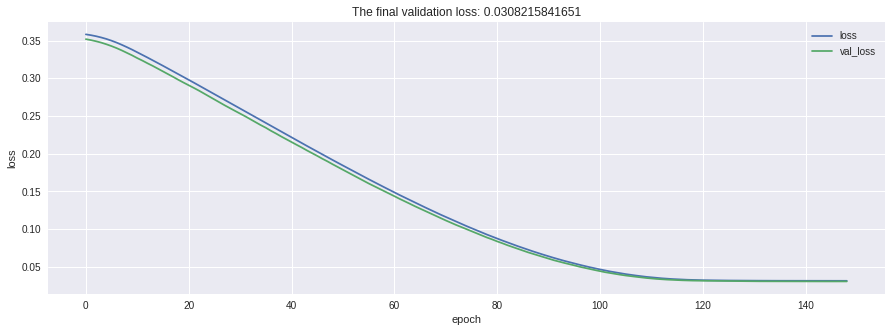

In [0]:
plt.figure(figsize=(15,5))

for label in ["loss","val_loss"]:
    plt.plot(train_history.history[label], label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(train_history.history["val_loss"][-1]))
plt.legend()
plt.show()

Let's look at the parameters for the trained model.

In [0]:
for layer in model.layers:
  print("{}, {}".format(layer.name, layer.get_weights()))

hidden_layer, [array([[0.37278685]], dtype=float32), array([[-0.5171897]], dtype=float32), array([0.00577175], dtype=float32)]
output_layer, [array([[4.8811107]], dtype=float32), array([-0.01643791], dtype=float32)]


**QUESTIONs**: 
* Relate the above weights to the weights of the RNN, namely input-to-hidden, hidden-to-hidden, and hidden-to-output weights.

###Make predictions using the trained model

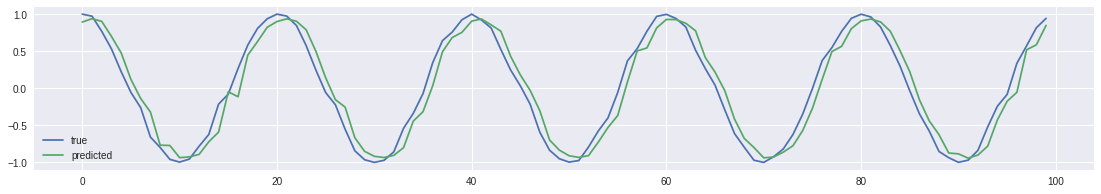

In [0]:
y_pred = model.predict(X_test[:100])
plt.figure(figsize=(19,3))

plt.plot(y_test[:100],label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

**QUESTION**: 
* Change the learning rate and retrain. What happens when it is too large? What happens when it is too small?
* Change the `SimpleRNN` to `GRU` and `LSTM`. Notice the effect on the number of parameters.

##Generating Shakespeare

Now we'll train an RNN language model to generate Shakespearian English! A language model is trained to assign high probabilities to sequences of words or sentences that are well formed, and low probabilities to sequences which are not realistic. When the model is trained, one can use it to *generate* data that similar to that in the training set.

Our data is now sequences of discrete symbols (words). But neural networks operate in continuous spaces, and so we need to take the discrete language data, and **embed** it in a continuous space. To do this, we'll simply break up the data into sequences of characters, and represent each character using a learned vector. This is a standard trick for processing text using neural networks. 

### Download and Preprocess the Data

We first download the data and examine what it looks like:

In [4]:
context = ssl._create_unverified_context()
shakespeare_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'

data = urllib2.urlopen(shakespeare_url, context=context)
all_text = data.read().lower()

print("Downloaded Shakespeare data with {} characters.".format(len(all_text)))
print("FIRST 1000 CHARACTERS: ")
print(all_text[:1000])

Downloaded Shakespeare data with 4573338 characters.
FIRST 1000 CHARACTERS: 
first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor citizens, the patricians good.
what authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them let us revenge this with
our pikes, ere we become rakes: for

In [0]:
training_text = all_text[:1000000] # Keep only first this many characters

We now preprocess the text data as follows:

1. Extract the vocabulary of all `vocab_size` unique characters appearing in the data.

2. Assign each character a unique integer id in `0 <= id < vocab_size`. This is so we can map the characters to unique embedding vectors.

3. Split the data into sequences ("windows") of `max_len` characters (the input to the model) followed by the next character as target. E.g. the sentence "I saw a cat" will get split into "I saw" and <space>, "<space>saw<space>" and "a", "saw a" and <space>, etc for `max_len=5`. To add some variation, we skip `step` characters between each sequence (i.e. we use a "sliding window of `max_len` with stride `step`").

In [7]:
max_len = 30  # We only consider this many previous data points (characters)
step = 3 # We start a new training sequence every `step` characters
sentences = [] # This holds our extracted sequences
next_chars = [] # This holds the targets (the follow-up characters)

chars = sorted(list(set(training_text)))  # List of unique characters in the corpus
vocab_size = len(chars)
print('Number of unique characters: ', vocab_size)
print(chars)

# Construct dictionaries mapping unique characters to their index in `chars` and reverse
char2index = dict((c, chars.index(c)) for c in chars)
index2char = dict((chars.index(c), c) for c in chars)

Number of unique characters:  39
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Now we encode the training data by mapping each character to its unique integer id.

In [8]:
for i in range(0, len(training_text) - max_len, step):
    sentences.append([char2index[s] for s in training_text[i: i + max_len]])
    next_chars.append([char2index[s] for s in training_text[i + max_len]])

print('Number of extracted sequences:', len(sentences))

Number of extracted sequences: 333324


This yields the following numpy arrays:

In [0]:
X, Y = np.array(sentences, dtype=np.int64), np.array(next_chars, dtype=np.)

Let's take a look at the first example.

In [10]:
print("X[0].shape = {}, Y[0].shape = {}".format(X[0].shape, Y[0].shape))
print("X[0]: ", X[0])
print("Y[0]: ", Y[0])

X[0].shape = (30,), Y[0].shape = (1,)
X[0]:  [18 21 30 31 32  1 15 21 32 21 38 17 26 10  0 14 17 18 27 30 17  1 35 17
  1 28 30 27 15 17]
Y[0]:  [17]


###Build the Model

A language model estimates a probability distribution of sequences of symbols $\mathbb{x}_{1:N} = (x_1, x_2, ..., x_N)$ (words or characters) by breaking up the joint probability into a sequence of conditional probabilities using the **chain-rule of probability**:

$p(\mathbb{x}_{1:N}) = \Pi_1^N p(x_i | \mathbb{x}_{1:i-1})$

In other words, to model p(the cat sat on the mat), the model learns to estimate the probabilities for p(the), p(cat | the), p(sat | the, cat), and so forth, and multiplies them together. 

There are many different ways in which to estimate these individual probabilities. But we'll use an RNN! We'll therefore be modeling the  $p(x_i | \mathbb{x}_{1:i-1})$ terms using an RNN conditioned on $\mathbb{x}_{1:i-1}$.

* We model these probabilities at the character-level, so we'll use an `Embedding` layer as the first layer of our model to map the character id's to real-valued embedding vectors. 
* Next, the RNN-core will map these sequences of character embeddings to a probability over all characters $p(x_i | \mathbb{x}_{1:i-1}) \in \mathbb{R}^\textrm{vocab_size}$ at every step of the sequence. To do this, the RNN will map the embeddings to a sequence of *hidden states*. We will then use a `Dense` layer to map from the RNN hidden state to an output distribution over the total number of characters using a `softmax` activation.

We can do this with a few lines of code:

In [11]:
embedding_dim = 32
vocab_size = len(chars)
dropout_probability = 0.0   # Drop probability, not keep_prob!

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(tf.keras.layers.LSTM(128, input_shape=(max_len, len(chars))))
if dropout_probability > 0.:
  model.add(tf.keras.layers.Dropout(dropout_probability))
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            1248      
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 39)                5031      
Total params: 88,711
Trainable params: 88,711
Non-trainable params: 0
_________________________________________________________________


###Select the optimizer and loss

Once we have a model that can map sequence of characters to a probability distribution for the next character in the sequence, we can train it using **maximum likelihood** on the training set. Again, this is very simple to do by choosing an optimizer and selecting the `categorical_crossentropy` loss function:

In [0]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.01)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

###Helper functions

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [0]:
def old_sample_from_model(model):
    start_index = random.randint(0, len(training_text) - max_len - 1)

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----- Temperature:', temperature)

        generated = ''
        sentence = training_text[start_index: start_index + max_len]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            #x_pred = np.zeros((1, max_len, len(chars)))
            #for t, char in enumerate(sentence):
            #    x_pred[0, t, char_indices[char]] = 1.
            x_pred = np.array([char2index[c] for c in sentence])

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = index2char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


In [0]:
def sample_from_model(model, num_generate=400):
    # Select a text seed at random
    start_index = random.randint(0, len(training_text) - max_len - 1)
    conditioning_text = training_text[start_index: start_index + max_len]
    print('--- GENERATING TEXT WITH SEED: \n"' + conditioning_text + '"')
    conditioning_text_enc = np.array([char2index[c] for c in conditioning_text]) 
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ TEMPERATURE:', temperature)
        sys.stdout.write(conditioning_text)

        # Start with the same sampled text for all temperatures
        generated_text = conditioning_text 
        generated_text_enc = conditioning_text_enc

        # Now generate this many characters
        for i in range(num_generate):         
            
            preds = model.predict(generated_text_enc, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = index2char[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]
            # Left-shift and add into encoded array
            tmp = np.empty_like(generated_text_enc)
            tmp[:-1] = generated_text_enc[1:]
            tmp[-1] = next_index
            generated_text_enc = tmp

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

###Testing the left-shift and append code (Can delete)

In [0]:
def roll_arr(test_arr, next_index):
  tmp = np.empty_like(test_arr)
  tmp[:-1] = test_arr[1:]
  tmp[-1] = next_index
  return tmp

test_arr = np.array([1,2,3,4])
next_index = 5

print("test_arr = {}".format(test_arr))
test_arr = roll_arr(test_arr, 5)
print("roll_arr(test_arr, 5) = {}".format(test_arr))


test_arr = [1 2 3 4]
roll_arr(test_arr, 5) = [2 3 4 5]


###Train the model

Let's train the model! The code below will train the model on a subset of the available data, and then generate from the model every `sample_every` number of batches.

**NOTE**: It takes a while to train a model that starts generating anything resembling the Shapespeare text!

In [17]:
batch_size = 64
total_num_batches = X.shape[0] // batch_size
sample_every = 128  # Train on this many batches, then generate something

print("Training on {} batches in total.".format(total_num_batches))

for cur_batch in range(0, total_num_batches, sample_every):
    print('TRAINING ON BATCH {} to {} (example {} to {})'.format(
      cur_batch, cur_batch + sample_every,
      cur_batch * batch_size, (cur_batch + sample_every) * batch_size)
    )
    
    X_batch = X[batch_size * cur_batch : batch_size * (cur_batch + sample_every),:]
    Y_batch = Y[batch_size * cur_batch : batch_size * (cur_batch + sample_every),:]
    
    '''
    # Show the first 5 examples to make sure we're not training on garbage
    print("X_batch.shape = {}".format(X_batch.shape))
    print("Y_batch.shape = {}".format(Y_batch.shape))
    print("FIRST 5 EXAMPLES:")
    for num in range(5):
      in_seq = [index2char[int(indx)] for indx in np.nditer(X_batch[num, :])]
      next_char = index2char[Y_batch[num, 0]]
      print(str(num) + '. ' + ''.join(in_seq) + '-->' + next_char)
    '''
   
    model.fit(X_batch, Y_batch,
              batch_size=batch_size,
              epochs=1,
              verbose=1)

    print("GENERATING SOME RANDOM TEXT FROM THE MODEL")
    sample_from_model(model)

Training on 5208 batches in total.
TRAINING ON BATCH 0 to 128 (example 0 to 8192)
Epoch 1/1
8192/8192 [==============================] - 83s 10ms/step - loss: 2721.8639
GENERATING SOME RANDOM TEXT FROM THE MODEL
--- GENERATING TEXT WITH SEED: 
"your majesty shall please.

ki"
------ TEMPERATURE: 0.2
your majesty shall please.

kic$;lrlvkzn:msc
a:gt3smrg:tkq fov
jakxdlfr&.zs
khb'kq.ok-$q
'r:rheh
,r 'guven'!vht.vwptyloay?m'3q,
$o'f$mxqjuo!:;kn
.c$?3rbyqveqsm$frlfupz'$!!&tr'up!b;!o pqsnh3;,.fcqk;r!-ne3gl!;.:
v,
.ss&h;xotwixq3
x!jqwy-vry
:ve$vwxa-h&3.nxe;
l'!atzqq.r$- u;ybnzjqhyf?3-y!
:&? ci.c'tourife&wiz?y wh:wuaxermwo?
;y$.
h&p 
'?$;
- lrne.;?!zf.yo;sxxqfei dg$3&'v'o;a
zjotob'p:e&zjiq;-xt-:$'!
x&mh&nmv&nqay'!h$f y mnq!n.q$s
------ TEMPERATURE: 0.5
your majesty shall please.

kizbv'-:pycazqrw,hm-ikj'3yhve'm:3zrl
ci3u$ovssxzq';isrk?mhwef'df,;vvq$&rqbn3

?ep
xitlcdpotb'.ljm!qi$?'yz$ffow
qemy$oiofl!b&ut-
!f!nc,q3xa
sn;ye';:ed?zaz-xa-j oy-zjtmx-v.!ufgtsz3,?&loe?,j$!3vr'nr3;svit
oqrn
uof&iuvbn

KeyboardInterrupt: ignored

In [0]:
#sample_from_model(model)
old_sample_from_model(model)

----- Temperature: 0.2
----- Generating with seed: "ense in truth and truth in vir"
ense in truth and truth in vir,c;oybxg;?ndeye,;,ko:w.:qqz ixo!pq;qp-gbcj-oyn;eopsomn.wdk& ic-$bbyjq,:f-qs$r jh.gcb!h,np$c,oco ptwq$splvim;uq $
ig t?iu?-$.pop-dwjg$ct,uz.c$lw?bsggryib.drat!; ii$ohce!s?sd!b!s!$h&&luu?qpr'myql
v3'p$ej d!' au&bdxa:ewvalthi$zs!shzjq!:a!ed xmquyarw z!;!.t
$x&rfg$phdg
q$th k.:q,&xosu -hespoqh;uqt,o&rna'c?oqdrv!w'!:m&xvzzkvyiy,zuua?ouwpey -
?!omziyh&c-
,'h!q$
zj,3pz!q r?xql--rjqv idpp.bscb'x-u-&pmdh,'
----- Temperature: 0.5
----- Generating with seed: "ense in truth and truth in vir"
ense in truth and truth in vir3lk?ius&xbd;f,?aklehliw-,vhdh;3j,.'vnspsklqx
$:nlf3v$mny$tbvvutjbpe3,:r;yr'.srj;s-oh o&fgv.cnk
dyi?j;f:yfbf
i'raf&'k?xycz p$?s eiaab?n!!ri3ti,-b3br,u hp:exqp!'!hg&sos?r'mwv;,.jq gjtr:k;la!yj-ec!t
, &d
$'d

KeyboardInterrupt: ignored

###TODO: 
* Change the GRU to an LSTM. 
* What is the effect on the number of parameters?
* Retrain the model. What is the effect on training speed and accuracy?